<a href="https://colab.research.google.com/github/anujdutt9/PyTorch-DeepLearning/blob/master/Denoising_Dirty_Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook, we'll implement a Convolutional AutoEncoder for denoising documents.

Dataset for this notebook is taken from here: https://www.kaggle.com/c/denoising-dirty-documents

## Imports

In [1]:
# Import Dependencies
import os
import albumentations as A
from glob import glob
import numpy as np
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Training Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


## Create Train Val Split

In [3]:
# Dataset Paths
fpath_clean_images = sorted(glob("./dataset/train_cleaned/*.png"))
fpath_noisy_images = sorted(glob("./dataset/train/*.png"))

In [4]:
# Check for sanity
assert len(fpath_clean_images) == len(fpath_noisy_images)

In [5]:
# Train Val Split
x_train, x_val, y_train, y_val = train_test_split(fpath_noisy_images, fpath_clean_images, test_size=0.1, random_state=101)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))

129 129
15 15


## Dataset Class

In [6]:
# Dataset
class DirtyDocsDataset(Dataset):
    def __init__(self, fpath_noisy, fpath_clean, transform):
        super(DirtyDocsDataset, self).__init__()
        
        self.transform = transform
        
        self.fpath_noisy_images = sorted(fpath_noisy)
        self.fpath_clean_images = sorted(fpath_clean)
        
        print(f"Found {len(self.fpath_noisy_images)} images.")
        
    
    def __len__(self):
        return len(self.fpath_clean_images)
    
    def __getitem__(self, idx):
        # Image: Feature, Label Paths
        fpath_img = self.fpath_noisy_images[idx]
        fpath_label = self.fpath_clean_images[idx]
        
        # Read Images
        noisy_img = np.uint8(Image.open(fpath_img).convert("RGB"))
        clean_img = np.uint8(Image.open(fpath_label).convert("RGB"))
        
        # Apply image transforms
        if self.transform is not None:
            aug_img = self.transform(image=noisy_img, image0=clean_img)
            noisy_img = aug_img['image']
            clean_img = aug_img['image0']
        
        # Convert image from uint8 to float
        noisy_img = noisy_img.astype(np.float32) / 255.
        clean_img = clean_img.astype(np.float32) / 255.
        
        # Convert (H,W,C) to (C,H,W)
        noisy_img = noisy_img.transpose(2,0,1)
        clean_img = clean_img.transpose(2,0,1)
        
        return torch.from_numpy(noisy_img), torch.from_numpy(clean_img)

In [7]:
# Train Transforms
train_transform = A.Compose(
    [
        A.Resize(height=420, width=540, interpolation=cv2.INTER_AREA, p=1.0),
        A.VerticalFlip(p=0.3),
        A.HorizontalFlip(p=0.4),
    ],
    additional_targets={'image0': 'image'}
)

# Val Transforms
val_transform = A.Compose(
    [
        A.Resize(height=420, width=540, interpolation=cv2.INTER_AREA, p=1.0),
    ],
    additional_targets={'image0': 'image'}
)

In [8]:
# Dataset
train_dataset = DirtyDocsDataset(fpath_noisy=x_train, 
                                 fpath_clean=y_train,
                                 transform=train_transform)

val_dataset = DirtyDocsDataset(fpath_noisy=x_val, 
                               fpath_clean=y_val,
                               transform=train_transform)

# Data Loader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=4,
                        shuffle=True,
                        num_workers=2,
                        pin_memory=True)

Found 129 images.
Found 15 images.


## Dataset Visualization

In [9]:
# Test Dataloader
train_imgs, train_labels = next(iter(train_loader))

In [10]:
train_imgs.shape, train_labels.shape

(torch.Size([4, 3, 420, 540]), torch.Size([4, 3, 420, 540]))

In [11]:
img = train_imgs[0].squeeze()
lbl = train_labels[0].squeeze()

In [12]:
img.shape, lbl.shape

(torch.Size([3, 420, 540]), torch.Size([3, 420, 540]))

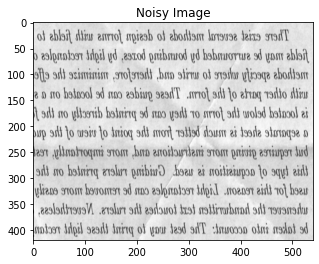

In [13]:
# Plot sample image
plt.title("Noisy Image")
plt.imshow(img.permute(1,2,0).numpy())

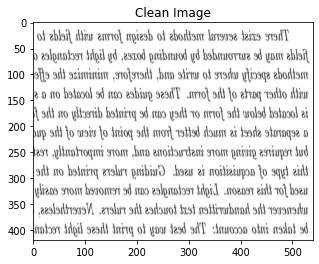

In [14]:
# Plot sample image
plt.title("Clean Image")
plt.imshow(lbl.permute(1,2,0).numpy())

## Model

In [15]:
# Model Basic Building Blocks

# Conv -> ReLU -> BN
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride, pad):
        super(ConvBNReLU, self).__init__()
        
        layers = []
        layers.append(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, stride=stride, padding=pad))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.BatchNorm2d(out_ch))
        
        self.down_conv_layer = nn.Sequential(*layers)
    
    def forward(self, inputs):
        x = self.down_conv_layer(inputs)
        
        return x

# TransposedConv -> ReLU -> BN
class TransposedConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride, pad, out_pad=0):
        super(TransposedConvBNReLU, self).__init__()
        
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, stride=stride, padding=pad, output_padding=out_pad))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.BatchNorm2d(out_ch))
        
        self.up_conv_layer = nn.Sequential(*layers)
    
    def forward(self, inputs):
        x = self.up_conv_layer(inputs)
        
        return x

In [16]:
# Model
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            ConvBNReLU(in_ch=3, out_ch=32, kernel=(3, 3), stride=(2, 2), pad=1),
            ConvBNReLU(in_ch=32, out_ch=64, kernel=(3, 3), stride=(2, 2), pad=1),
            ConvBNReLU(in_ch=64, out_ch=128, kernel=(3, 3), stride=(2, 2), pad=1),
            ConvBNReLU(in_ch=128, out_ch=256, kernel=(7, 7), stride=(1, 1), pad=0),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            TransposedConvBNReLU(in_ch=256, out_ch=128, kernel=(7, 7), stride=(1, 1), pad=0, out_pad=0),
            TransposedConvBNReLU(in_ch=128, out_ch=64, kernel=(3, 3), stride=(2, 2), pad=1, out_pad=0),
            TransposedConvBNReLU(in_ch=64, out_ch=32, kernel=(3, 3), stride=(2, 2), pad=1, out_pad=1),
        )
        
        # Output
        self.out = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        
    def forward(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        x = self.out(x)
        
        return torch.sigmoid(x)

In [17]:
# Instantiate the Model
model = ConvAutoEncoder()
model.to(device)

ConvAutoEncoder(
  (encoder): Sequential(
    (0): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
      

## Training

In [18]:
# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [19]:
# Train the Model
EPOCHS = 20

model.train()

for epoch in range(EPOCHS):
    running_loss = 0
    correct = 0
    
    for data in train_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch: {epoch}, loss: {running_loss/len(train_loader)}")

# Evaluate Trained Model
running_loss = 0
correct = 0
    
model.eval()
for data in val_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)

    running_loss += loss.item()

print(f"\nValidation - loss: {running_loss/len(val_loader)}")

Epoch: 0, loss: 0.2167345118342024
Epoch: 1, loss: 0.14730829068205573
Epoch: 2, loss: 0.09104497933929617
Epoch: 3, loss: 0.05744113998882698
Epoch: 4, loss: 0.04016192296914982
Epoch: 5, loss: 0.02915334678960569
Epoch: 6, loss: 0.02202270958911289
Epoch: 7, loss: 0.01763574821366505
Epoch: 8, loss: 0.01440355105494911
Epoch: 9, loss: 0.012105093478704945
Epoch: 10, loss: 0.010492898664917007
Epoch: 11, loss: 0.009346708598913568
Epoch: 12, loss: 0.008412265275238138
Epoch: 13, loss: 0.007662358002342058
Epoch: 14, loss: 0.006719141761123231
Epoch: 15, loss: 0.006234604230319912
Epoch: 16, loss: 0.005943285075552536
Epoch: 17, loss: 0.0054372186546750145
Epoch: 18, loss: 0.005375587734196222
Epoch: 19, loss: 0.004984459035437216

Validation - loss: 0.004588344832882285


## Model Inference

In [20]:
# Test Images
test_images = sorted(glob("./dataset/test/*.png"))
len(test_images)

72

In [21]:
# Put model in evaluation mode
model.eval()

ConvAutoEncoder(
  (encoder): Sequential(
    (0): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ConvBNReLU(
      (down_conv_layer): Sequential(
        (0): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
      

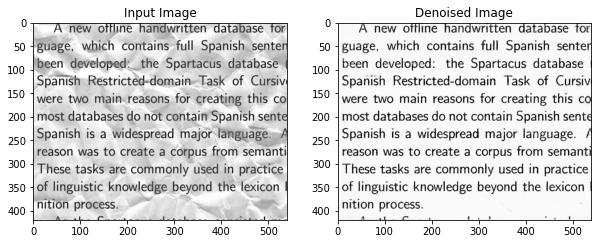

In [24]:
#@title Image Browser  { run: "auto", vertical-output: true }
dim = (540,420)

idx = 8 #@param {type:"slider", min:0, max:72, step:1}

img = np.uint8(Image.open(test_images[idx]).convert("RGB"))
img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

# Input Image
input_img = img.copy()

img = img.astype(np.float32) / 255.
img = img.transpose(2,0,1)
img = np.expand_dims(img, 0)

img_tensor = torch.from_numpy(img).to(device)
pred = model(img_tensor)

# Predicted Image
output = pred.cpu().detach().numpy().squeeze()
output = output.transpose(1,2,0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(input_img)
ax1.set_title("Input Image")

ax2.imshow(output)
ax2.set_title("Denoised Image")

plt.show()